In [57]:
import pandas as pd
import numpy as np

from tensorflow import keras

In [58]:
viz_model = keras.models.load_model('./../Datasets/Fall examples/Fall examples/Farseeing/Data/ResNet_Conv2D_Split.h5')

In [59]:
test_path = "./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/"

In [60]:
from os import walk

# columns = ['Time','Acc_X','Acc_Y','Acc_Z','Fall_indicator']
# train_data = pd.DataFrame() #columns=columns)
data_for_fall_test=[]

for (dirpath, dirnames, filenames) in walk(test_path):
    
    for file in filenames:
        print(dirpath+file)
        data = pd.read_csv(dirpath+file)
        data.columns = ['Time','Rel_Time','Acc_X','Acc_Y','Acc_Z','Mg_X','Mg_Y','Mg_Z','Ang_X','Ang_Y','Ang_Z','Fall_indicator']
        data_for_fall_test.append(data)

./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-01-2011-02-19-15-59-57.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_42990421-02-2011-02-19-22-58-03.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-01-2008-06-26-07-27-49.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_72858619-02-2008-06-26-11-29-16.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_74827807-07-2009-02-16-19-10-44.csv
./../Datasets/Fall examples/Fall examples/Farseeing/Data/Test/F_96201346-03-2011-05-21-06-19-42.csv


In [61]:
from scipy import stats
#Creates windows of size=20 and steps forward by 1
def create_dataset(X, Y, feature_size=20, step_size=1):
    window_X, window_Y = [], []
    for i in range(0, len(X) - feature_size, step_size):
        #Feature size=20 (size of window)
        window_data = X.iloc[i:(i + feature_size),:]
        #Get all the 20 labels
        labels = Y.iloc[i: i + feature_size]
        #Append for each 20 sized windows, each stepped forward by 1
        window_X.append(window_data)
        #Get the max value- If window contains the row that has fall data then window labelled as fall
        #The fall indicator can be any value >0 dependng on severity of fall
        window_Y.append(labels.max())
    return (window_X), np.array(window_Y).reshape(-1, 1)

In [62]:
def to_features(data):
    #Flattens the window data into one row
    #Will get 20 rows of 3 columns each = 60 data points in each row
    feature_columns = ['Acc_X','Acc_Y','Acc_Z']
    sensor_values = data[feature_columns].values 
    features = sensor_values.flatten()
    return features

In [63]:
#SAME TESTING SET
from itertools import chain


#Same process of split for testing data
test_X_window = []
test_Y_window = []
for dataset in data_for_fall_test:
    #Get the fall event location in the file (only one file at a time)
    fall_event_loc = dataset[dataset['Fall_indicator']>0].index
    data_index_lists = []
    #Get 2 seconds of data around fall event
    for fall_loc in fall_event_loc:
        #2s of data - 1.5sec before fall, 0.5sec after fall
        data_index_lists.append(list(range(fall_loc-40,fall_loc+20)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X, test_each_Y = create_dataset(
        dataset_sample[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample[['Fall_indicator']],
        feature_size=20
    )
    
    #Adding only non-fall data from the files
    data_index_lists_non_fall=[]
    for fall_loc in fall_event_loc:
        #2s of data - 10 seconds before fall, duration is 2 seconds
        data_index_lists_non_fall.append(list(range(fall_loc-600,fall_loc-560)))
    #Get all the indices as a list    
    drop_arr = list(chain.from_iterable(data_index_lists_non_fall))
    #Take only those indices that correspond to 2 seconds of data around fall event
    dataset_sample_non_fall = dataset.iloc[drop_arr]
    

    #Create windowed data for the file
    test_each_X_non_fall, test_each_Y_non_fall = create_dataset(
        dataset_sample_non_fall[['Acc_X', 'Acc_Y', 'Acc_Z']],
        dataset_sample_non_fall[['Fall_indicator']],
        feature_size=20
    )
    
    #Flatten the windowed data to get 60 features in a row
    test_each_X_flat = np.stack([to_features(d) for d in test_each_X])
    test_each_X_flat_non_fall = np.stack([to_features(d) for d in test_each_X_non_fall])
    
    #Append the data of each file
    test_X_window.append(test_each_X_flat)
    test_X_window.append(test_each_X_flat_non_fall)
    
    
    test_Y_window.append(test_each_Y)
    test_Y_window.append(test_each_Y_non_fall)
    
    

In [64]:
test_X = np.concatenate(test_X_window, axis = 0)
test_X

array([[-5.1077 , -0.60521,  7.354  , ..., -4.7643 , -0.54891,  6.4087 ],
       [-5.1077 , -0.57706,  7.6599 , ..., -4.564  , -0.49261,  6.3253 ],
       [-4.8502 , -0.40816,  7.2428 , ..., -4.3923 , -0.35187,  6.1307 ],
       ...,
       [-0.7869 , -1.6186 ,  9.7173 , ..., -0.87274, -1.5904 ,  9.7173 ],
       [-0.7869 , -1.6467 ,  9.6617 , ..., -0.87274, -1.6186 ,  9.7173 ],
       [-0.75828, -1.6749 ,  9.6061 , ..., -0.87274, -1.6186 ,  9.6617 ]])

In [65]:
from keras import models

for i in range(len(viz_model.layers)):
    layer = viz_model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

1 conv2d (None, 20, 3, 60)
4 conv2d_2 (None, 20, 3, 64)
7 conv2d_3 (None, 20, 3, 64)
8 conv2d_4 (None, 20, 3, 64)
13 conv2d_6 (None, 20, 3, 64)
16 conv2d_7 (None, 20, 3, 64)
20 conv2d_9 (None, 20, 3, 64)
23 conv2d_10 (None, 20, 3, 64)
27 conv2d_12 (None, 20, 3, 128)
30 conv2d_13 (None, 20, 3, 128)
31 conv2d_14 (None, 20, 3, 128)
36 conv2d_16 (None, 20, 3, 128)
39 conv2d_17 (None, 20, 3, 128)
43 conv2d_19 (None, 20, 3, 128)
46 conv2d_20 (None, 20, 3, 128)
50 conv2d_22 (None, 20, 3, 128)
53 conv2d_23 (None, 20, 3, 128)
57 conv2d_25 (None, 20, 3, 256)
60 conv2d_26 (None, 20, 3, 256)
61 conv2d_27 (None, 20, 3, 256)
66 conv2d_29 (None, 20, 3, 256)
69 conv2d_30 (None, 20, 3, 256)
73 conv2d_32 (None, 20, 3, 256)
76 conv2d_33 (None, 20, 3, 256)
80 conv2d_35 (None, 20, 3, 256)
83 conv2d_36 (None, 20, 3, 256)
87 conv2d_38 (None, 20, 3, 256)
90 conv2d_39 (None, 20, 3, 256)
94 conv2d_41 (None, 20, 3, 256)
97 conv2d_42 (None, 20, 3, 256)
101 conv2d_44 (None, 20, 3, 512)
104 conv2d_45 (None, 20, 3, 

In [66]:
layers_viz =[4,36,69,120]

#outputs from chosen layers
layer_outputs = [viz_model.layers[layer_no].output for layer_no in layers_viz]

#Get activation models given input and the output of the chosen layers
activation_model = models.Model(inputs=viz_model.input, outputs=layer_outputs) 

In [67]:
# Returns a list of 12 Numpy arrays: one array per layer activation for the first test value
activations = activation_model.predict(test_X[305].reshape(1,20,3,1)) 

In [68]:
len(activations)

4

In [69]:
(activations[1]).shape

(1, 20, 3, 128)

In [70]:
def visualize(data):
    x_axis = data[:,0]
    y_axis = data[:,1]
    z_axis = data[:,2]
    
    pyplot.plot(range(0,20),x_axis,label='x_axis', c='blue')
    pyplot.plot(range(0,20),y_axis,label='y_axis', c='green')
    pyplot.plot(range(0,20),z_axis,label='z_axis', c='red')

In [71]:
np.mean(activations[1][0, :, :, 5])

-0.37942684

In [72]:
mean_arr=[]
for i in range(activations[3].shape[-1]):
    mean_arr.append(np.mean(activations[3][0, :, :, i]))

In [73]:
sorted(range(len(mean_arr)), key=lambda k: mean_arr[k])

[254,
 462,
 498,
 131,
 248,
 181,
 470,
 413,
 153,
 464,
 235,
 77,
 429,
 185,
 339,
 276,
 205,
 290,
 93,
 152,
 506,
 488,
 360,
 285,
 274,
 23,
 238,
 468,
 36,
 14,
 102,
 396,
 161,
 353,
 107,
 214,
 439,
 469,
 436,
 422,
 26,
 282,
 101,
 147,
 476,
 305,
 490,
 234,
 508,
 448,
 424,
 266,
 402,
 224,
 29,
 332,
 197,
 237,
 31,
 445,
 466,
 17,
 500,
 171,
 403,
 373,
 433,
 66,
 87,
 471,
 127,
 283,
 187,
 212,
 132,
 146,
 326,
 366,
 167,
 358,
 313,
 347,
 481,
 405,
 196,
 384,
 104,
 269,
 316,
 379,
 100,
 331,
 195,
 138,
 361,
 114,
 84,
 367,
 228,
 32,
 315,
 25,
 221,
 296,
 24,
 453,
 135,
 70,
 191,
 390,
 58,
 120,
 75,
 52,
 103,
 318,
 15,
 79,
 260,
 351,
 94,
 183,
 67,
 6,
 286,
 258,
 510,
 267,
 186,
 454,
 380,
 244,
 348,
 459,
 150,
 419,
 329,
 435,
 33,
 86,
 407,
 320,
 165,
 392,
 179,
 450,
 489,
 9,
 163,
 160,
 112,
 3,
 35,
 154,
 227,
 27,
 321,
 182,
 463,
 193,
 53,
 340,
 355,
 363,
 381,
 115,
 188,
 190,
 189,
 83,
 272,
 233,
 30

In [74]:
activations_zero = [50,39,56,40,52,0,9,47,49,37,29,44]
activations_one = [16,120,48,32,6,113,116,57,43,51,3,90]
activations_two = [117,17,136,82,112,100,183,5,160,163,110,56]
activations_three = [131,462,254,248,267,63,168,507,304,223,497,410]

In [343]:
data_temp = test_X[90].reshape(1,20,3,1)
x_axis = data_temp[:,0]


In [96]:
activations[0].shape

(1, 20, 3, 64)

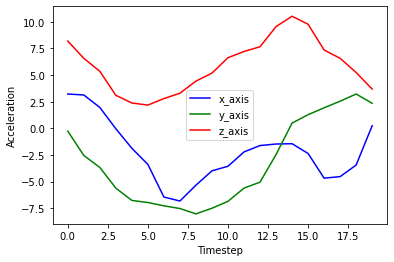

In [75]:
#fall - 333, 155
#non-fall - 305, 240
from matplotlib import pyplot

fall_data = test_X[305].reshape(1,20,3,1)
fall_data_viz = fall_data[0, :, :, 0]
x_axis = fall_data_viz[:,0]
y_axis = fall_data_viz[:,1]
z_axis = fall_data_viz[:,2]
    
pyplot.plot(range(0,20),x_axis,label='x_axis', c='blue')
pyplot.plot(range(0,20),y_axis,label='y_axis', c='green')
pyplot.plot(range(0,20),z_axis,label='z_axis', c='red')
pyplot.xlabel("Timestep")
pyplot.ylabel("Acceleration")
pyplot.legend()
pyplot.show()

In [97]:
def visualize(ax,data):
    x_axis = data[:,0]
    y_axis = data[:,1]
    z_axis = data[:,2]
    
    ax.plot(range(0,20),x_axis,label='x_axis', c='blue')
    ax.plot(range(0,20),y_axis,label='y_axis', c='green')
    ax.plot(range(0,20),z_axis,label='z_axis', c='red')
    ax.set_xticks([])
    ax.axis(ymin=-5,ymax=5)

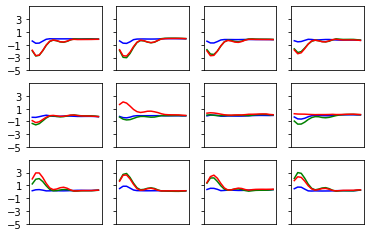

In [98]:
#fall - 333,
#non-fall 115,
from matplotlib import pyplot

layer_activation = activations[3]
ix=1
fig,axes = pyplot.subplots(3, 4, sharex='col', sharey='row')
for i in range(3):
    for j in range(4):
        # specify subplot and turn of axis
    #     ax.set_xticks([])
    #   ax.set_yticks([])
        # plot filter channel in grayscale
        visualize(axes[i,j],layer_activation[0, :, :, activations_three[ix-1]])
        
        axes[i,j].set_yticks(np.arange(-5, 5,2.0))
        ix += 1